In [14]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [15]:
# Import necessary libraries
from src.models import RNNModel
import numpy as np
import matplotlib.pyplot as plt
import scipy
import os
from os.path import dirname, join as pjoin
import torch
from torch import nn
import scipy.signal as signal

# Set data type and device
dtype = torch.float
#device = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device("cpu")

# Close all open plots
plt.close('all')

In [16]:
# Load data from file
folderpath = os.getcwd()
filepath = pjoin(folderpath, 'input.mat')
data_in = scipy.io.loadmat(filepath)
filepath = pjoin(folderpath, 'output.mat')
data_out = scipy.io.loadmat(filepath)

# Extract data from dictionary
dExp, yExp, dExp_val, yExp_val, time__ = data_in['dExp'], data_out['yExp'], \
    data_in['dExp_val'], data_out['yExp_val'], data_in['time__']
    
nExp = yExp.size


In [17]:
# Create time vector
#t = np.arange(0, np.size(dExp[0, 0], 1) * Ts, Ts)
t = time__

# Set end time
t_end = t.size

# Initialize input and output tensors
input_size = 5
u = torch.zeros(nExp, t_end, input_size)
y = torch.zeros(nExp, t_end, 2)

# Set input number
inputnumberD = input_size-1

# Fill input and output tensors with data
for j in range(nExp):
    #inputActive = (torch.from_numpy(dExp[0, j]))
    #if input_size ==4:
     #   u[j, :, :] = (torch.from_numpy(dExp[0, j][:, :-1])) #suppress last column
    #else :
    u[j, :, :] = (torch.from_numpy(dExp[0, j]))        
    y[j, :, :] = (torch.from_numpy(yExp[0, j]))
    
    #u[j, :, 4] = torch.from_numpy(signal.medfilt((u[j, :, 4]).numpy(), 13))

# Set random seed for reproducibility
seed = 1
torch.manual_seed(seed)

In [11]:
import torch
import torch.nn as nn
import numpy as np

# Set number of epochs
epochs = 300

# Set dimensions for RNN layers
idd = input_size
odd = yExp[0, 0].shape[1]

# Initialize variable to track the smallest loss
best_loss = 1
best_hdd_ldd = None 

for hdd in [100]:  # hdd goes from 10 to 100 (inclusive), step by 10       150-200
    for ldd in [2]: #1-5
        print(f"Training RNN with hdd={hdd} and ldd={ldd}")
        
        # Initialize RNN model
        RNN = RNNModel(idd, hdd, ldd, odd)
        
        # Define loss function
        MSE = nn.MSELoss()

        # Define optimization method
        learning_rate = 5.0e-3
        optimizer = torch.optim.Adam(RNN.parameters(), lr=learning_rate)
        optimizer.zero_grad()

        # Initialize array to store loss values
        LOSS = np.zeros(epochs)

        # Train the RNN model
        for epoch in range(epochs):
            # Adjust learning rate at certain epochs
            if epoch == epochs - epochs // 2:
                learning_rate = 1.0e-3
                optimizer = torch.optim.Adam(RNN.parameters(), lr=learning_rate)
            if epoch == epochs - epochs // 6:
                learning_rate = 1.0e-4
                optimizer = torch.optim.Adam(RNN.parameters(), lr=learning_rate)
            
            optimizer.zero_grad()

            # Get RNN output for training data
            yRNN = RNN(u)
            yRNN = torch.squeeze(yRNN)

            # Calculate loss and backpropagate
            loss = MSE(yRNN, y)
            loss.backward()
            optimizer.step()

            # Print loss for the current epoch
            print(f"Epoch: {epoch + 1} \t||\t Loss: {loss.item()}")
            LOSS[epoch] = loss.item()
        print(f"loss for model with hdd={hdd}, ldd={ldd} : loss={LOSS[-1]}")

        # Check if this model has the smallest loss
        final_loss = LOSS[-1]  # Loss at the last epoch
        if final_loss < best_loss:
            best_loss = final_loss
            best_hdd_ldd = (hdd, ldd)
            
            # Save the model parameters with the lowest loss
            torch.save(RNN.state_dict(), 'best_RNN.pth')
            print(f"Best model so far saved with hdd={hdd}, ldd={ldd} and loss={best_loss}")
            
print(f"Training completed. Best model was with hdd={best_hdd_ldd[0]}, ldd={best_hdd_ldd[1]} and loss={best_loss}")

Training RNN with hdd=100 and ldd=2
Epoch: 1 	||	 Loss: 0.36943432688713074
Epoch: 2 	||	 Loss: 0.04847632348537445
Epoch: 3 	||	 Loss: 0.12511011958122253
Epoch: 4 	||	 Loss: 0.022540302947163582
Epoch: 5 	||	 Loss: 0.022866129875183105
Epoch: 6 	||	 Loss: 0.024617085233330727
Epoch: 7 	||	 Loss: 0.004587252624332905
Epoch: 8 	||	 Loss: 0.01950233057141304
Epoch: 9 	||	 Loss: 0.02012960985302925
Epoch: 10 	||	 Loss: 0.00623260997235775
Epoch: 11 	||	 Loss: 0.004963628016412258
Epoch: 12 	||	 Loss: 0.012573698535561562
Epoch: 13 	||	 Loss: 0.010851925238966942
Epoch: 14 	||	 Loss: 0.00432219123467803
Epoch: 15 	||	 Loss: 0.004373032599687576
Epoch: 16 	||	 Loss: 0.008029134012758732
Epoch: 17 	||	 Loss: 0.009182171896100044
Epoch: 18 	||	 Loss: 0.006478659342974424
Epoch: 19 	||	 Loss: 0.003541042096912861
Epoch: 20 	||	 Loss: 0.003914152272045612
Epoch: 21 	||	 Loss: 0.0059911590069532394
Epoch: 22 	||	 Loss: 0.006375291384756565
Epoch: 23 	||	 Loss: 0.004665261600166559
Epoch: 24 	||

In [18]:

#Set dimensions for RNN layers
idd = input_size
hdd = 50
ldd = 2
odd = yExp[0, 0].shape[1]

# Initialize RNN model
RNN = RNNModel(idd, hdd, ldd, odd)
# Load the model parameters before starting a new training session
#RNN.load_state_dict(torch.load('parameters_RNN.pth'))

# Define loss function
MSE = nn.MSELoss()

# Define optimization method
learning_rate = 5.0e-3
optimizer = torch.optim.Adam(RNN.parameters(), lr=learning_rate)
optimizer.zero_grad()

# Set number of epochs
epochs = 300

# Initialize array to store loss values
LOSS = np.zeros(epochs)



# Train the RNN model
for epoch in range(epochs):
    # Adjust learning rate at certain epochs
    if epoch == epochs - epochs / 2:
        learning_rate = 1.0e-3
        optimizer = torch.optim.Adam(RNN.parameters(), lr=learning_rate)
    if epoch == epochs - epochs / 6:
        learning_rate = 1.0e-4
        optimizer = torch.optim.Adam(RNN.parameters(), lr=learning_rate)
    optimizer.zero_grad()
    loss = 0

    # Get RNN output for training data
    yRNN = RNN(u)
    yRNN = torch.squeeze(yRNN)
    

    # Calculate loss and backpropagate
    loss = MSE(yRNN, y)
    loss.backward()
    optimizer.step()
    

    # Print loss for current epoch
    print(f"Epoch: {epoch + 1} \t||\t Loss: {loss}")
    LOSS[epoch] = loss
    
    # Save model parameters every 15 epochs
    if (epoch + 1) % 15 == 0:
        torch.save(RNN.state_dict(), f'parameters_RNN.pth')
        print(f"Model parameters saved at epoch {epoch + 1}")


Epoch: 1 	||	 Loss: 0.6267819404602051
Epoch: 2 	||	 Loss: 0.23573799431324005
Epoch: 3 	||	 Loss: 0.021967647597193718
Epoch: 4 	||	 Loss: 0.07933931052684784
Epoch: 5 	||	 Loss: 0.08317670226097107
Epoch: 6 	||	 Loss: 0.016937347128987312
Epoch: 7 	||	 Loss: 0.010038290172815323
Epoch: 8 	||	 Loss: 0.037932414561510086
Epoch: 9 	||	 Loss: 0.03951185569167137
Epoch: 10 	||	 Loss: 0.020602997392416
Epoch: 11 	||	 Loss: 0.005568071734160185
Epoch: 12 	||	 Loss: 0.005820183549076319
Epoch: 13 	||	 Loss: 0.01483109313994646
Epoch: 14 	||	 Loss: 0.019373031333088875
Epoch: 15 	||	 Loss: 0.015173777937889099
Model parameters saved at epoch 15
Epoch: 16 	||	 Loss: 0.007687031757086515
Epoch: 17 	||	 Loss: 0.0036939927376806736
Epoch: 18 	||	 Loss: 0.005281585268676281
Epoch: 19 	||	 Loss: 0.009331408888101578
Epoch: 20 	||	 Loss: 0.011358506046235561
Epoch: 21 	||	 Loss: 0.009757718071341515
Epoch: 22 	||	 Loss: 0.006333855912089348
Epoch: 23 	||	 Loss: 0.003857649862766266
Epoch: 24 	||	 Lo

In [19]:
# Initialize input and output tensors for validation data
"""
#Set dimensions for RNN layers
idd = input_size
hdd = 50
ldd = 2
odd = yExp[0, 0].shape[1]
RNN = RNNModel(idd, 50, 2, odd)

# Define loss function
MSE = nn.MSELoss()
RNN.load_state_dict(torch.load('best_RNN.pth'))"""
nExp = yExp_val.size
uval = torch.zeros(nExp, t_end, input_size)
yval = torch.zeros(nExp, t_end, 2)

# Fill input and output tensors with validation data
for j in range(nExp):
    inputActive = (torch.from_numpy(dExp_val[0, j]))#[:,:-1]))
    uval[j, :, :] = torch.unsqueeze(inputActive[:,inputnumberD], 1)
    yval[j, :, :] = (torch.from_numpy(yExp_val[0, j]))
    #uval[j, :, 4] = torch.from_numpy(signal.medfilt((uval[j, :, 4]).numpy(), 25))

# Get RNN output for validation data
yRNN_val = RNN(uval)
yRNN_val = yRNN_val.unsqueeze_(0)

# Calculate loss for validation data
loss_val = MSE(yRNN_val, yval)

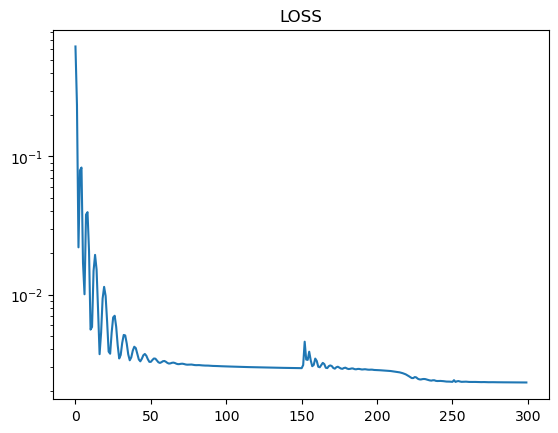

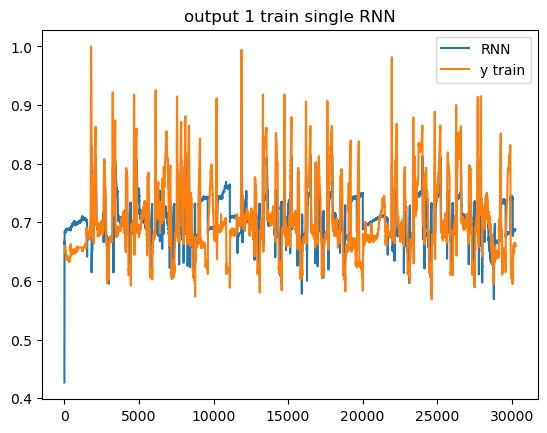

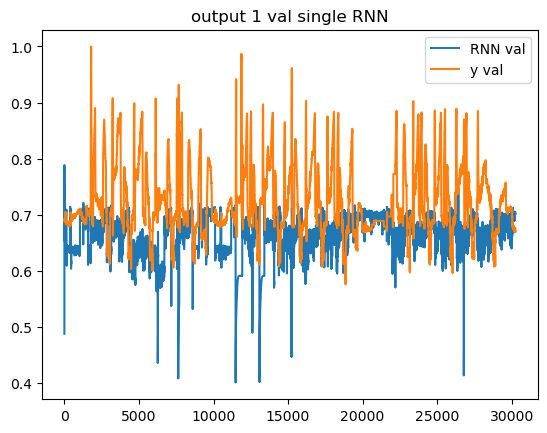

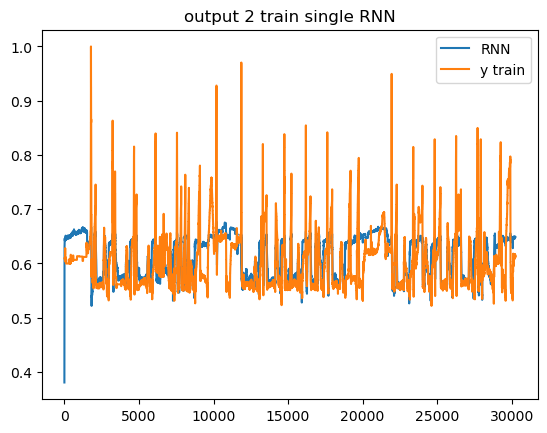

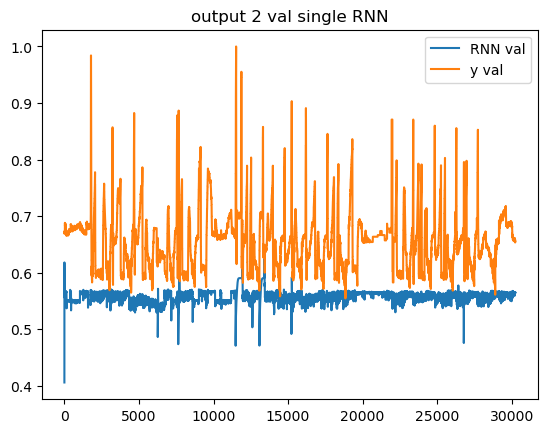

Loss Validation single RNN: 0.010612822137773037


In [ ]:
# Plot loss over epochs
plt.figure('8')
plt.plot(LOSS)
plt.yscale('log')
plt.title("LOSS")
plt.show()

# Plot output 1 for training data
plt.figure('9')
plt.plot(yRNN[0, :, 0].detach().numpy(), label='RNN')
plt.plot(y[0, :, 0].detach().numpy(), label='y train')
plt.title("output 1 train single RNN")
plt.legend()
plt.show()

# Plot output 1 for validation data
plt.figure('10')
plt.plot(yRNN_val[0, :, 0].detach().numpy(), label='RNN val')
plt.plot(yval[0, :, 0].detach().numpy(), label='y val')
plt.title("output 1 val single RNN")
plt.legend()
plt.show()

# Plot output 2 for training data
plt.figure('11')
plt.plot(yRNN[0, :, 1].detach().numpy(), label='RNN')
plt.plot(y[0, :, 1].detach().numpy(), label='y train')
plt.title("output 2 train single RNN")
plt.legend()
plt.show()

# Plot output 2 for validation data
plt.figure('12')
plt.plot(yRNN_val[0, :, 1].detach().numpy(), label='RNN val')
plt.plot(yval[0, :, 1].detach().numpy(), label='y val')
plt.title("output 2 val single RNN")
plt.legend()
plt.show()

# Save RNN output and validation data to file
#scipy.io.savemat('data_singleRNN_sysID.mat', dict(yRENm_val=yRNN_val.detach().numpy(), yval=yval.detach().numpy()))

# Print validation loss
print(f"Loss Validation single RNN: {loss_val}")

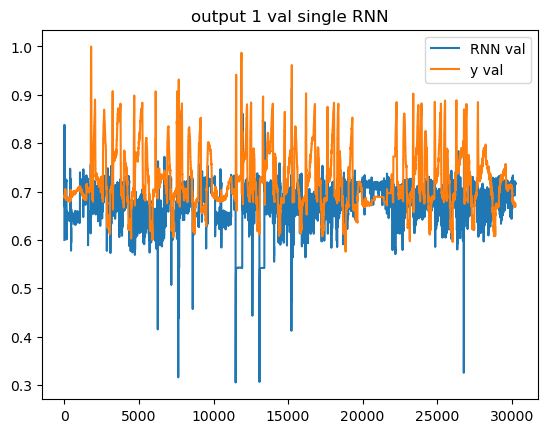

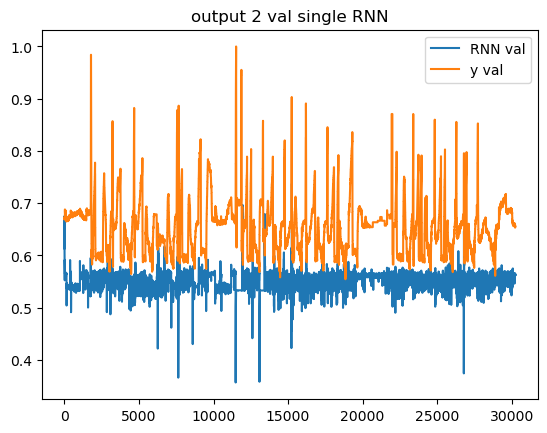

In [10]:
# Plot output 1 for validation data
plt.figure('10')
plt.plot(yRNN_val[0, :, 0].detach().numpy(), label='RNN val')
plt.plot(yval[0, :, 0].detach().numpy(), label='y val')
plt.title("output 1 val single RNN")
plt.legend()
plt.show()
# Plot output 2 for validation data
plt.figure('12')
plt.plot(yRNN_val[0, :, 1].detach().numpy(), label='RNN val')
plt.plot(yval[0, :, 1].detach().numpy(), label='y val')
plt.title("output 2 val single RNN")
plt.legend()
plt.show()


In [ ]:
# (1,2) 0.0033869
# (10,2) 0.00294932
# (50,2) 0.0022162
# (100,2) 0.00232311

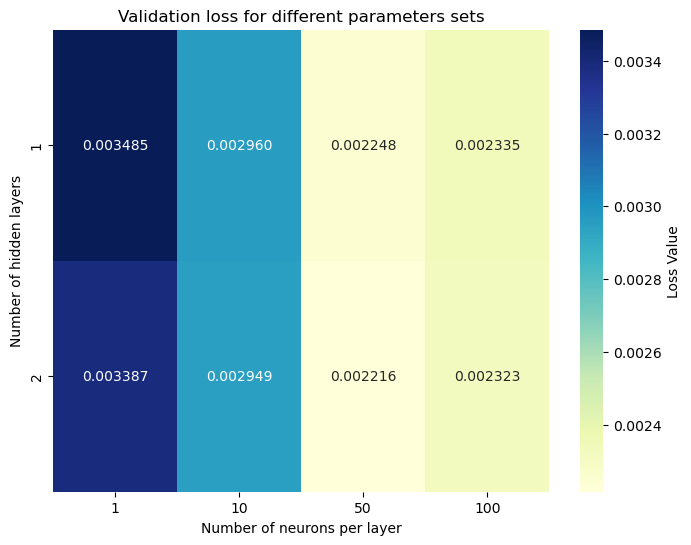

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Data for neurons, layers, and loss values
data = {
    "neurons": [1, 10, 50, 100, 1, 10, 50, 100],
    "layers": [1, 1, 1, 1, 2, 2, 2, 2],
    "loss": [0.00348502, 0.0029604, 0.002248, 0.0023354, 0.0033869, 0.00294932, 0.0022162, 0.00232311]
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Pivot the data for heatmap
pivot_table = df.pivot(index="layers", columns="neurons", values="loss")

# Plotting the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Loss Value'}, fmt=".6f")
plt.title("Validation loss for different parameters sets")
plt.xlabel("Number of neurons per layer")
plt.ylabel("Number of hidden layers")
plt.show()
